This script uses Python interface to the XGBoost library. 
In order to install XGBoost using ```pip``` you need to have a C-compiler available. For instance, for Linux you need to run ```apt-get install build-essential``` before running ```pip install xgboost```.

In [1]:
# necessary libraries
import numpy as np
import pandas as pd
from time import time
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load data
train_set = pd.read_csv('../../transfusion.train.csv')
test_set = pd.read_csv('../../transfusion.test.csv')

In [3]:
# split data into X, y, and test
# remove ID and Total.Volume.Donated columns
X = train_set.loc[:, ['Months since Last Donation', 'Number of Donations', 'Months since First Donation']]
y = train_set.loc[:, 'Made Donation in March 2007']
test = test_set.loc[:,['Months since Last Donation', 'Number of Donations', 'Months since First Donation']]

In [4]:
def add_features(data):
    data['Average Months Per Donation'] = (data['Months since First Donation'] - data['Months since Last Donation']) / data['Number of Donations']
    data['Distance to Average'] = np.exp(-np.abs(data['Average Months Per Donation'] - data['Months since Last Donation']))
    return data

X = add_features(X)
test = add_features(test)

In [5]:
# remove outliers
mask = ~((X['Number of Donations'] > 30) | (X['Months since Last Donation'] > 50) | (X['Average Months Per Donation'] > 25))
X = X[mask]
y = y[mask]
print('Number of outliers: ' + str(sum(~mask)))

Number of outliers: 11


In [6]:
# define model
clf = XGBClassifier()

In [7]:
# utility function to report best scores
# from sklearn documentation
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [8]:
# specify parameters and distributions to sample from
param_dist = { "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
               "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0],
               "max_depth": range(1, 21, 2)
             }

In [9]:
# run randomized search for best hyperparameters
n_iter_search = 200
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   scoring="neg_log_loss",
                                   n_iter=n_iter_search,
                                   random_state=42)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 115.69 seconds for 200 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.526 (std: 0.030)
Parameters: {'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.01}

Model with rank: 2
Mean validation score: -0.544 (std: 0.035)
Parameters: {'n_estimators': 900, 'max_depth': 1, 'learning_rate': 0.01}

Model with rank: 3
Mean validation score: -0.548 (std: 0.037)
Parameters: {'n_estimators': 1000, 'max_depth': 1, 'learning_rate': 0.01}



In [10]:
# use best model from above to retrain a model with all train data
param = {'objective': 'binary:logistic', 
         'learning_rate': 0.01, 
         'max_depth': 1, 
         'n_estimators': 500}
model = XGBClassifier(**param)
model.fit(X, y, eval_metric='logloss')
y_test = model.predict_proba(test)

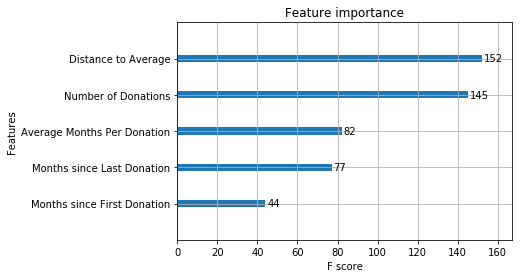

In [11]:
# plot feature importance using built-in function
from xgboost import plot_importance
from matplotlib import pyplot
%matplotlib inline
plot_importance(model)
pyplot.show()

In [12]:
df = pd.DataFrame({'': test_set['Unnamed: 0'].values.astype(int), 'Made Donation in March 2007': y_test[:, 1]})
df.to_csv('xgbSubmission-5.csv', index=False)

On October 24, 2017 this script got a score of 0.4541, leading to a rank of 608/3389.